In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
import sionna as sn
from sionna.phy.utils import complex_normal
from sionna.phy.signal import fft, ifft
from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt
# import tensorflow_probability as tfp
import math as m
pi = tf.constant(m.pi)

2026-02-08 17:44:54.520134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770565494.532650   13821 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770565494.536806   13821 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770565494.546424   13821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770565494.546436   13821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770565494.546438   13821 computation_placer.cc:177] computation placer alr

In [2]:
def nextpow2(N):
    """ Function for finding the next power of 2 """
    n = 1
    while n < N: n *= 2
    return n

### Phase noise function in Dileepa's paper

In [3]:
class PhaseNoise(Layer):
    def __init__(self, model_type='10', bandwidth=7e9, fc=140e9, n_samples=1024, **kwargs):
        super().__init__()
        self._real_dtype = tf.dtypes.as_dtype(self.dtype).real_dtype
        self.model_type = model_type
        self.bandwidth = bandwidth
        self.fc = fc
        self.n_samples = n_samples

        samples = 2 * nextpow2(n_samples)
        self.samples = samples  # upper limit

        fvec = (self.bandwidth / 2) * np.linspace(0, 1, self.samples)

        # 3GPP TR38.803 v14.2.0 70GHz PLL phase noise model Table 6.1.10.1-3
        if self.model_type == '10':

            fref = 70e9  # 70 GHz reference
            psd0 = 8894  # 39.49 dB
            fz = [3e3, 396e3, 754e6]
            az = [2.37, 2.7, 2.53]
            fp = [1, 1.55e6, 30e6]
            ap = [3.3, 3.3, 1]

            lf = psd0 * np.ones([1, self.samples])  # PN PSD
            for n in range(3):
                lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
            # scale to carrier frq
            lf = lf * np.square((self.fc / fref))

        # 3GPP TR38.803 v14.2.0 UE model 1 Table 6.1.11.2-1
        if self.model_type == '11':
            # loop bandwidth
            LBW = 187e3  # Hz

            # all vectors contain values for and in order of
            # REF clk  PLL  VCO 1/f^2  VCO 1/f^3
            # Figure Of Merit
            FOM = [-215, -240, -175, -130]
            # zero-point frequency
            fz = [float('inf'), 1e4, 50.3e6, float('inf')]
            # Power consumption (mW)
            P = [10, 20, 20, 20]
            # zero-point power
            k = [2, 1, 2, 3]

            f_low = np.take(fvec, np.where(fvec <= LBW))
            f_high = np.take(fvec, np.where(fvec > LBW))

            PSD0 = FOM + 20 * np.log10(self.fc) - 10 * np.log10(
                P)  # x dB, actually P/1mW

            fn = lambda f, psd0, fz, k: np.power(10.0, psd0 / 10.0) * (
                    (1.0 + np.power((f / fz), k)) / (1.0 + np.power(f, k)))

            lf = np.concatenate([fn(f_low, PSD0[0], fz[0], k[0]) + fn(f_low, PSD0[1], fz[1], k[1]),
                                 fn(f_high, PSD0[2], fz[2], k[2]) + fn(f_high, PSD0[3], fz[3], k[3])], axis=1)

        # 3GPP TR38.803 v14.2.0 BS model 2
        if self.model_type == '12':
            # loop bandwidth
            LBW = 112e3  # Hz

            # all vectors contain values for and in order of
            # REF clk  PLL  VCO 1/f^2  VCO 1/f^3
            # Figure Of Merit
            FOM = [-240, -245, -187, -130]
            # zero-point frequency
            fz = [float('inf'), 1e4, 8e6, float('inf')]
            # Power consumption (mW)
            P = [10, 20, 50, 50]
            # zero-point power
            k = [2, 1, 2, 3]

            f_low = np.take(fvec, np.where(fvec <= LBW))
            f_high = np.take(fvec, np.where(fvec > LBW))

            PSD0 = FOM + 20 * np.log10(self.fc) - 10 * np.log10(P)  # x dB, actually P/1mW

            fn = lambda f, psd0, fz, k: np.power(10.0, psd0 / 10.0) * (
                    (1.0 + np.power((f / fz), k)) / (1.0 + np.power(f, k)))

            lf = np.concatenate([fn(f_low, PSD0[0], fz[0], k[0]) + fn(f_low, PSD0[1], fz[1], k[1]),
                                 fn(f_high, PSD0[2], fz[2], k[2]) + fn(f_high, PSD0[3], fz[3], k[3])], axis=1)


        if self.model_type == '13':
            # Texas Instruments LMX2595 at 20GHz carrier freq
            # Fig 14 of data sheet revised April 2019

            # measured PN PSD is approximated by polynomials
            # (similar to 3GPP case 10 with n,m = 1,2)
            # f_meas = [1e2 1e3 1e4 1e5 1e6 10e6 40e6 95e6 100e6 fp(end)];
            # psd_meas = [-82.8 -92.2 -100.9 -104.1 -116.5 -140.5 -147.2 -147.7 -147.7 -147.7];

            fref = 20e9  # 70 GHz reference
            psd0 = 10 ** ((-72.0) / 10)  # 39.49 dB
            fz = [3e4, 1.75e7]
            az = [1.4, 2.55]
            fp = [1e1, 3e5]
            ap = [1, 2.95]

            lf = psd0 * np.ones([1, self.samples])  # PN PSD
            for n in range(2):
                lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
            # scale to carrier frq
            lf = lf * np.square((self.fc / fref))
        # NEU 130 Ghz
        if self.model_type == '16':

            fref = 130e9  # 70 GHz reference
            psd0 = 10 ** ((-66.5) / 10)  # 39.49 dB
            fz = [0.01e6, 6.0e6, 10.0e6]
            az = [2.0,2.0,2.0]
            fp = [0.005e6,0.03e6,5.0e6]
            ap = [2.0,2.0,2.0]

            lf = psd0 * np.ones([1, self.samples])  # PN PSD
            for n in range(3):
                lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
            # scale to carrier frq
            #lf = lf * np.square((self.fc / fref))

        # remove DC
        lf = np.concatenate([[[0]], lf[:, 1:]], axis=-1)
        self.lf = tf.convert_to_tensor(lf, dtype=tf.float32)


    @tf.function
    def call(self, x):

        # White complex Gaussian sequence
        src_t = complex_normal([tf.shape(x)[0], self.samples])
        src_f = tf.signal.fft(src_t)  # fft(src_t)

        # Apply PSD weights
        f_a = tf.complex(tf.sqrt(self.lf), tf.cast(0.0, tf.float32)) * src_f

        # Symmetric spectrum(PSD is also even symmetric) --> real time - domain process
        f_a = tf.concat([f_a, tf.math.conj(tf.reverse(f_a[:, 1:], axis=[-1]))], axis=-1)
        theta_t = tf.signal.ifft(f_a)  # ifft(f_a)

        # Normalize to have correct variance
        theta_norm = theta_t * tf.cast(tf.sqrt(2 / (1 / self.bandwidth)), dtype=tf.complex64)

        # Take the required length from the middle (fftshift)
        required_samples_start_idx = tf.cast(self.samples / 2, dtype=tf.int32)

        pn_var = tf.math.reduce_variance(
            theta_norm[:, required_samples_start_idx:required_samples_start_idx + self.n_samples])

        phase_noise = tf.math.exp(
            1j * theta_norm[:, required_samples_start_idx:required_samples_start_idx + self.n_samples])
        y = x * phase_noise

        return y, pn_var, phase_noise

    def plot_psd(self):
        # Plot the PSD
        fig = plt.figure()
        fvec = (self.bandwidth / 2) * np.linspace(0, 1, self.samples)
        PSD = 10 * np.log10(np.squeeze(self.lf.numpy()))

        # Main plot
        ax1 = fig.add_subplot(111)
        ax1.semilogx(fvec, PSD)
        ax1.grid(True)
        ax1.set_xlabel('Frequency offset [Hz]')
        ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
        ax1.set_xlim([1e2, 1e10])
        plt.tight_layout()  # Adjust layout for subplots
        #return ax
        plt.show()

### Testing phase noise added with modulated filtered symbols

36.02060079574585


/tmp/ipykernel_21164/3592784115.py:251: RuntimeWarning: divide by zero encountered in log10
  PSD = 10 * np.log10(np.squeeze(self.lf.numpy()))


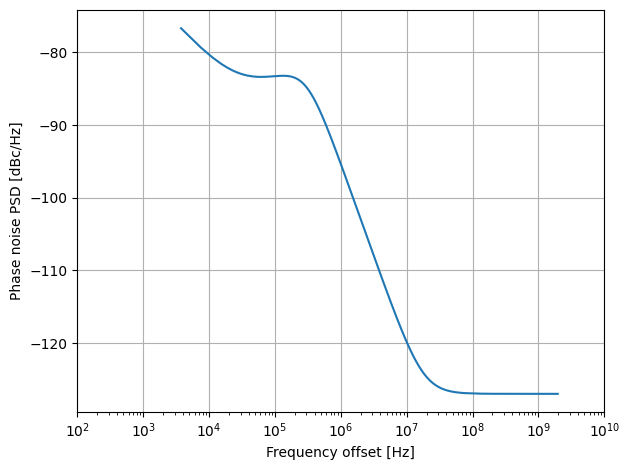

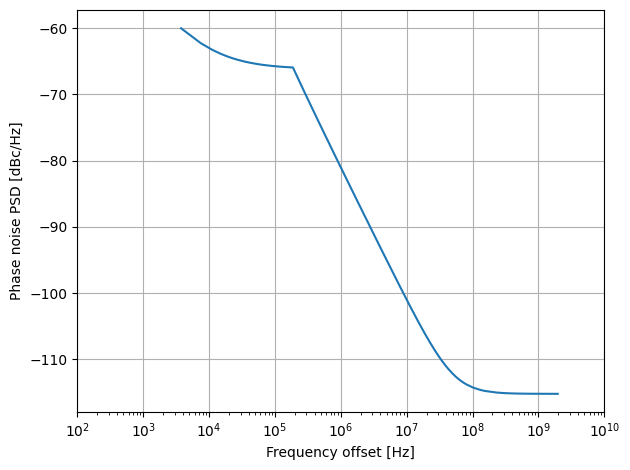

In [70]:
# for testing

import sionna as sn
import sionna.phy
tf.config.run_functions_eagerly(True)

total_samples = 4096
block_size = 512*64
sps = 4
batch_size = 1 #tf.cast(total_samples/block_size, tf.int32)
bw = 960e3*4096
fc = 220e9
ebno_db = 30
no = sn.phy.utils.ebnodb2no(ebno_db,
                        num_bits_per_symbol=4,
                        coderate=1.0)
print(10*np.log10(1/no))

filtlength = 32

constellation = sn.phy.mapping.Constellation("qam", num_bits_per_symbol=4) # 16QAM
mapper = sn.phy.mapping.Mapper(constellation=constellation)
demapper = sn.phy.mapping.Demapper("app", constellation=constellation, hard_out=False)
binary_source = sn.phy.mapping.BinarySource()
channel = sn.phy.channel.AWGN()
upsampler = sn.phy.signal.Upsampling(samples_per_symbol=sps)

tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                  samples_per_symbol=sps,
                                                  span_in_symbols=filtlength)
rx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                             samples_per_symbol=sps,
                                             span_in_symbols=filtlength)

downsampler = sn.phy.signal.Downsampling(samples_per_symbol=sps,
                                          offset=rx_filter.length - 1,
                                          num_symbols=block_size)
pn_tx = PhaseNoise(model_type='13', bandwidth=bw, fc=fc, n_samples=(block_size+filtlength)*sps)
pn_tx.plot_psd()
pn_rx = PhaseNoise(model_type='11', bandwidth=bw, fc=fc, n_samples=(block_size+filtlength)*sps)
pn_rx.plot_psd()
# ber = sn.utils.BitErrorRate()
rate_ = 0
pn_var_avg_tx = 0
pn_var_avg_rx = 0



In [71]:
print(pn_tx.samples)
print(pn_tx.n_samples)
print(pn_tx.fc)
print(pn_tx.bandwidth)
print(pn_tx.model_type)


524288
131200
220000000000.0
3932160000.0
13


In [72]:
for i in range(1):
    bits = binary_source([batch_size,block_size* 4])
    x = mapper(bits)
    x_ups = upsampler(x)
    x_filt = tx_filter(x_ups)
    print(x_filt.shape)
    x_pn, pn_var_tx, only_phase_n_tx = pn_tx(x_filt)
    y_chan = channel(x_pn, no)
    y_pn, pn_var_rx, _ = pn_rx(y_chan)
#     y_filt = rx_filter(y_pn)
#     y = downsampler(y_filt)
#     llr = demapper(y, no)
#     llr = tf.reshape(llr,[batch_size, block_size, 4])
#     bits = tf.reshape(bits, [batch_size, block_size, 4])
#     bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=bits,
#                                                   logits=llr)
#     rate = bce / tf.math.log(2.)  # (blocks, RE per block, bit per RE)
#     hs = tf.cast(4, tf.float32)  # (1,)
#     rate = tf.reduce_mean(hs - tf.reduce_sum(rate, axis=2))  # (1,)
#     rate_ = rate+ rate_
#     #print('TX var :{} RX var:{}'.format(pn_var_tx, pn_var_rx))
#     pn_var_avg_tx = pn_var_tx+pn_var_avg_tx
#     pn_var_avg_rx = pn_var_rx + pn_var_avg_rx
#
#     #ber_sim = ber(bits, b_hat)
# print('RATE : {}'.format(rate_.numpy()/100.0))
# print('PN VAR TX: {}'.format(pn_var_avg_tx/100.0))
# print('PN VAR RX: {}'.format(pn_var_avg_rx / 100.0))
#
# # plt.figure()
# # plt.scatter(np.real(x_pn), np.imag(x_pn))
# # plt.scatter(np.real(constellation.points), np.imag(constellation.points))
# # plt.show()
#
# plt.figure()
# plt.scatter(np.real(y), np.imag(y))
# plt.scatter(np.real(constellation.points), np.imag(constellation.points))
# plt.show()

(1, 131200)


### Testing whether above class actually generates phase noise with desired PSD

In [73]:
bandwidth = 960e3*4096
samples = 131200
delta_f = bandwidth / tf.cast(samples, tf.float32)

In [74]:
hFPwr_list = []
pn_without_carrier = only_phase_n_tx - tf.complex(1.0, 0.0)

hF = tf.signal.fft(pn_without_carrier)/ (
    tf.cast(samples, tf.complex64) * tf.sqrt(tf.cast(delta_f, tf.complex64))
)

hFPwr = tf.math.real(hF * tf.math.conj(hF))  # linear PSD
hFPwr_list.append(hFPwr)

hFPwr_stack = tf.stack(hFPwr_list, axis=0)
hFPwr_avg = tf.signal.fftshift(tf.reduce_mean(hFPwr_stack, axis=0))
fvec_3 = np.arange(-samples//2, samples//2) / samples * bandwidth
hFPwr_dB = tf.squeeze(10.0 * tf.math.log(hFPwr_avg) / tf.math.log(10.0))

fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
fvec = fvec[1:]
# PSD = 10 * np.log10(np.squeeze(lf))

In [78]:
fvec = (bandwidth / 2) * np.linspace(0, 1, pn_tx.samples)
PSD = 10 * np.log10(np.squeeze(pn_tx.lf.numpy()))

print(fvec.shape)
print(PSD.shape)


(524288,)
(524288,)


/tmp/ipykernel_21164/3083001778.py:2: RuntimeWarning: divide by zero encountered in log10
  PSD = 10 * np.log10(np.squeeze(pn_tx.lf.numpy()))


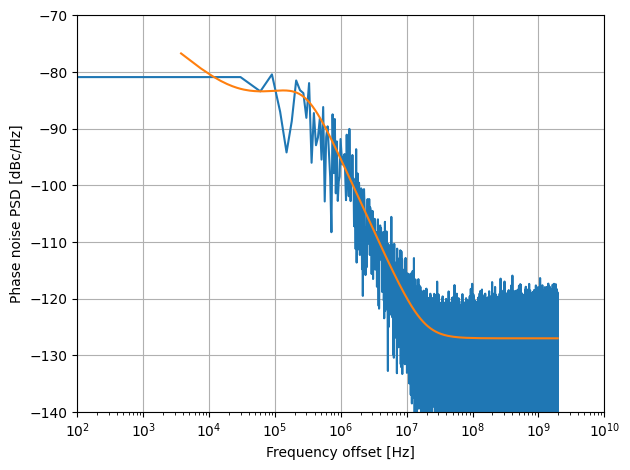

In [77]:
# Plot the PSD
fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.semilogx(fvec_3, hFPwr_dB)
ax1.semilogx(fvec, PSD)
# ax1.semilogx(fvec, PSD)
ax1.grid(True)
ax1.set_xlabel('Frequency offset [Hz]')
ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
ax1.set_xlim([1e2, 1e10])
ax1.set_ylim([-140, -70])
plt.tight_layout()  # Adjust layout for subplots
#return ax
plt.show()

#### The desired and actual PSDs are approximately identical

### Trying out a separate method

In [21]:
%reset

In [22]:
import numpy as np
from sionna.phy.utils import complex_normal
import tensorflow as tf
import matplotlib.pyplot as plt

In [23]:
sps = 4
block_size = 10
filtlength = 32
bandwidth = 960e3*4096
fc = 220e9
# n_samples = (block_size+filtlength)*sps
n_samples = 10**6

# samples = 2 * nextpow2(n_samples)

samples = n_samples
batch_size = 1

# fvec = (bandwidth / 2) * np.linspace(0, 1, samples)

fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
fvec = fvec[1:]


In [24]:
fref = 20e9  # 70 GHz reference
psd0 = 10 ** ((-72.0) / 10)  # 39.49 dB
fz = [3e4, 1.75e7]
az = [1.4, 2.55]
fp = [1e1, 3e5]
ap = [1, 2.95]

lf = psd0 * np.ones([1, len(fvec)])  # PN PSD
for n in range(2):
    lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / (1 + np.power((fvec / fp[n]), ap[n]))
# scale to carrier frq
lf = lf * np.square((fc / fref))

In [27]:
x = tf.cast(tf.ones([batch_size, n_samples]),tf.complex128)

In [28]:
### For Troubleshooting

# # White complex Gaussian sequence
# src_t = complex_normal([tf.shape(x)[0], samples])
# src_f = tf.signal.fft(src_t)  # fft(src_t)
#
# # Apply PSD weights
# f_a = tf.complex(tf.sqrt(lf), tf.cast(0.0, tf.float64)) * tf.cast(src_f,tf.complex128)
#
# # Symmetric spectrum(PSD is also even symmetric) --> real time - domain process
# dc = tf.complex(tf.ones([batch_size, 1], dtype=tf.float64), tf.zeros([batch_size, 1], dtype=tf.float64))
#
# f_a = tf.concat([dc, f_a, tf.math.conj(tf.reverse(f_a, axis=[-1]))], axis=-1)
# theta_t = tf.signal.ifft(f_a)  # ifft(f_a)
#
# # Normalize to have correct variance
# theta_norm = theta_t * tf.cast(tf.sqrt(2 / (1 / bandwidth)), dtype=tf.complex128)
#
# # Take the required length from the middle (fftshift)
# required_samples_start_idx = tf.cast(samples / 2, dtype=tf.int32)
#
# pn_var = tf.math.reduce_variance(
#     theta_norm[:, required_samples_start_idx:required_samples_start_idx + n_samples])
#
# phase_noise = tf.math.exp(1j * theta_norm[:, required_samples_start_idx:required_samples_start_idx + n_samples])
# y = x * phase_noise
#
# phase_noise = tf.cast(phase_noise,tf.complex64)
# pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)
#
# hF = tf.signal.fft(pn_without_carrier[:,:samples])/ tf.cast((tf.sqrt(n_samples*bandwidth)/2),tf.complex64)
# hFPwr = 10*tf.math.log(tf.squeeze(tf.math.real(hF * tf.math.conj(hF))))/2.3026 # /log(10)

In [29]:
hFPwr_list = []
n_iter = 40

delta_f = bandwidth / tf.cast(samples, tf.float32)

for itervalue in range(n_iter):
    tf.print('iter: ',itervalue)

    src_f = complex_normal([batch_size, samples])*(tf.sqrt(tf.cast(delta_f, tf.complex64)))*samples

    psd_squared = tf.concat([tf.math.conj(tf.reverse(lf, axis=[-1])),lf], axis=-1)

    f_a = tf.cast(src_f, tf.complex128) * tf.complex(tf.sqrt(psd_squared), tf.cast(0.0,tf.float64))

    theta_use = tf.signal.ifft(tf.signal.fftshift(f_a))

    phase_noise = tf.exp(1j*tf.cast(tf.sqrt(2.0),tf.complex128)* tf.complex(tf.math.real(theta_use),tf.cast(0.0,tf.float64)))
    phase_noise = tf.cast(phase_noise, tf.complex64)

    pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)

    # --- PSD estimation ---

    hF = tf.signal.fft(pn_without_carrier)/ (
        tf.cast(n_samples, tf.complex64) * tf.sqrt(tf.cast(delta_f, tf.complex64))
    )

    hFPwr = tf.math.real(hF * tf.math.conj(hF))  # linear PSD
    hFPwr_list.append(hFPwr)

hFPwr_stack = tf.stack(hFPwr_list, axis=0)
hFPwr_avg = tf.signal.fftshift(tf.reduce_mean(hFPwr_stack, axis=0))
fvec_3 = np.arange(-samples//2, samples//2) / samples * bandwidth
hFPwr_dB = tf.squeeze(10.0 * tf.math.log(hFPwr_avg) / tf.math.log(10.0))

fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
fvec = fvec[1:]
PSD = 10 * np.log10(np.squeeze(lf))


iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39


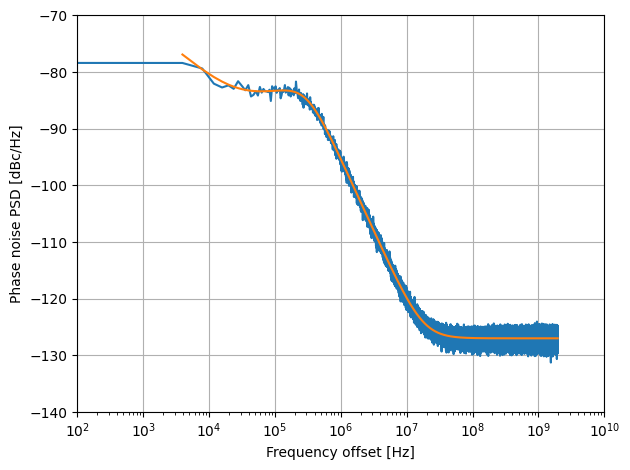

In [30]:

# Plot the PSD
fig = plt.figure()

# Main plot
ax1 = fig.add_subplot(111)
ax1.semilogx(fvec_3, hFPwr_dB)
ax1.semilogx(fvec, PSD)
ax1.grid(True)
ax1.set_xlabel('Frequency offset [Hz]')
ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
ax1.set_xlim([1e2, 1e10])
ax1.set_ylim([-140, -70])
plt.tight_layout()  # Adjust layout for subplots
#return ax
plt.show()

### Testing correlation with autocorrelation

In [11]:
PSD_linear = 10**(PSD / 10)  # PSD in linear units


In [12]:
df = fvec[1] - fvec[0]  # frequency resolution


In [13]:
R_phi = np.fft.ifft(PSD_linear)
R_phi = np.fft.fftshift(np.real(R_phi))# center zero lag
# Scaling
R_phi = R_phi*bandwidth

In [14]:
N = len(PSD_linear)
tau = np.fft.fftshift(np.fft.fftfreq(N, d=df))


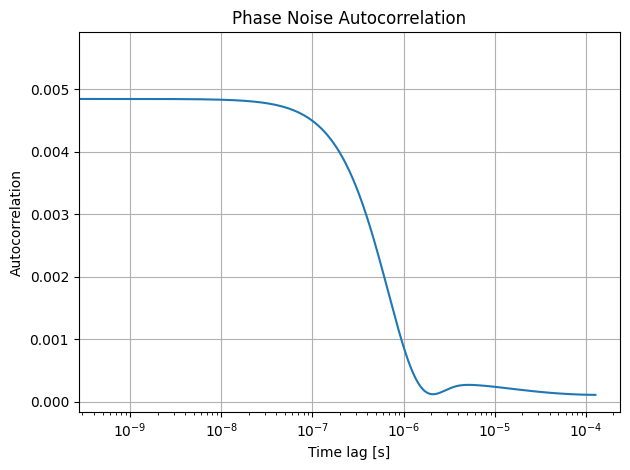

In [16]:
plt.figure()
plt.semilogx(tau, R_phi)
plt.grid(True)
plt.xlabel('Time lag [s]')
plt.ylabel('Autocorrelation')
plt.title('Phase Noise Autocorrelation')
plt.tight_layout()
plt.show()


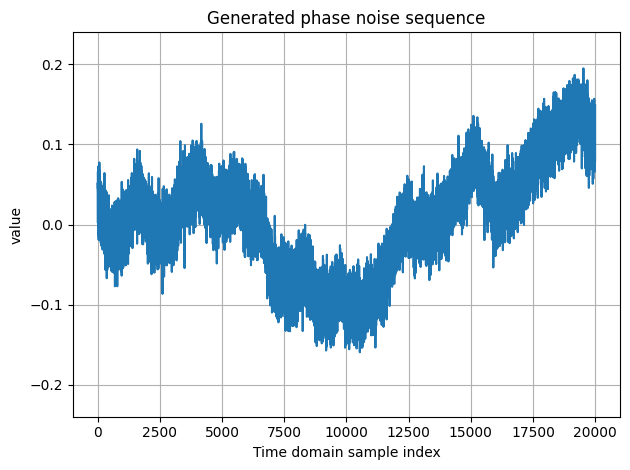

In [663]:
plt.figure()
indices_array = np.arange(20000)
plt.plot(indices_array, tf.math.real(theta_use[0,:20000]).numpy())
plt.grid(True)
plt.xlabel('Time domain sample index')
plt.ylabel('value')
plt.title('Generated phase noise sequence')
plt.ylim([-0.24, 0.24])
plt.tight_layout()
plt.show()

### Building new phase noise class using alternative method

In [14]:
import sionna as sn
from scipy.io import loadmat
import tensorflow_probability as tfp

In [15]:
class PhaseNoise_Tx:
    def __init__(self, fc, bandwidth, samples,
                 n_iter=1,
                 psd_db=-72.0,
                 fref=20e9,
                 fz=[3e4, 1.75e7],
                 az=[1.4, 2.55],
                 fp=[1e1, 3e5],
                 ap=[1, 2.95]):

        self.fc = fc
        self.bandwidth = bandwidth
        self.samples = samples
        self.n_iter = n_iter
        fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
        fvec = fvec[1:]

        # ----- Build PSD -----
        psd0 = 10 ** (psd_db / 10)

        lf = psd0 * np.ones([1, len(fvec)])

        for n in range(2):
            lf = lf * (1 + np.power((fvec / fz[n]), az[n])) / \
                      (1 + np.power((fvec / fp[n]), ap[n]))

        # scale to carrier frequency
        lf = lf * np.square((fc / fref))

        # Tensor version
        self.lf = tf.constant(lf, dtype=tf.float64)

        self.delta_f = bandwidth / tf.cast(samples, tf.float32)

    def _generate_pn(self, batch_size):
        # Complex Gaussian source in frequency domain
        src_f = (tf.complex(
                    tf.random.normal([batch_size, self.samples]),
                    tf.random.normal([batch_size, self.samples])
                 )
                 * tf.sqrt(tf.cast(self.delta_f, tf.complex64))
                 * self.samples)

        # Mirror PSD
        psd_squared = tf.concat([
            tf.math.conj(tf.reverse(self.lf, axis=[-1])),
            self.lf
        ], axis=-1)

        f_a = tf.cast(src_f, tf.complex128) * tf.complex(
                    tf.sqrt(psd_squared),
                    tf.cast(0.0, tf.float64)
              )

        theta_use = tf.signal.ifft(tf.signal.fftshift(f_a))

        phase_noise = tf.exp(
            1j * tf.cast(tf.sqrt(2.0), tf.complex128) *
            tf.complex(tf.math.real(theta_use),
                       tf.cast(0.0, tf.float64))
        )

        return tf.cast(phase_noise, tf.complex64)

    # ------------------------------------------------------------

    def __call__(self, symbols):
        """
        symbols : [batch_size, samples] complex64
        returns : phase-noise corrupted symbols
        """

        batch_size = tf.shape(symbols)[0]

        for itervalue in range(self.n_iter):
            # tf.print("iter: ", itervalue)

            phase_noise = self._generate_pn(batch_size)

            # Remove carrier if needed (same as your code)
            pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)

            # Corrupt symbols

            print(phase_noise.shape)
            symbols = symbols * phase_noise

        return symbols, pn_without_carrier


In [16]:
class PhaseNoise_Rx:
    def __init__(self, fc, bandwidth, samples,
                 n_iter=1,
                 fom_vec=[-215, -240, -175, -130],
                 fz_vec=[np.inf, 1e4, 50.30e6, np.inf],
                 p_vec=[10, 20, 20, 20],
                 k_vec=[2, 1, 2, 3]):

        self.fc = fc
        self.bandwidth = bandwidth
        self.samples = samples
        self.n_iter = n_iter
        fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
        fvec = fvec[1:]

        # ----- Build PSD -----
        fom = np.asarray(fom_vec)[:, None]
        fz  = np.asarray(fz_vec)[:, None]
        p   = np.asarray(p_vec)[:, None]
        k   = np.asarray(k_vec)[:, None]

        PSD0 = fom + 20 * np.log10(fc) - 10 * np.log10(p)
        S_ref = PSD0 + 10*np.log10((1 + (fvec / fz)**k) / (1 + fvec**k))
        f_loop = 187e3

        S_lin = 10**(S_ref / 10)
        S_out = np.where(
            fvec < f_loop,
            S_lin[0] + S_lin[1],
            S_lin[2] + S_lin[3]
        )
        # S_out_dB = 10 * np.log10(S_out)
        # Tensor version
        self.lf = tf.constant(S_out, dtype=tf.float64)

        self.delta_f = bandwidth / tf.cast(samples, tf.float32)

    def _generate_pn(self, batch_size):
        # Complex Gaussian source in frequency domain
        src_f = (tf.complex(
                    tf.random.normal([batch_size, self.samples]),
                    tf.random.normal([batch_size, self.samples])
                 )
                 * tf.sqrt(tf.cast(self.delta_f, tf.complex64))
                 * self.samples)

        # Mirror PSD
        psd_squared = tf.concat([
            tf.math.conj(tf.reverse(self.lf, axis=[-1])),
            self.lf
        ], axis=-1)

        f_a = tf.cast(src_f, tf.complex128) * tf.complex(
                    tf.sqrt(psd_squared),
                    tf.cast(0.0, tf.float64)
              )

        theta_use = tf.signal.ifft(tf.signal.fftshift(f_a))

        phase_noise = tf.exp(
            1j * tf.cast(tf.sqrt(2.0), tf.complex128) *
            tf.complex(tf.math.real(theta_use),
                       tf.cast(0.0, tf.float64))
        )

        return tf.cast(phase_noise, tf.complex64)

    # ------------------------------------------------------------

    def __call__(self, symbols):
        """
        symbols : [batch_size, samples] complex64
        returns : phase-noise corrupted symbols
        """

        batch_size = tf.shape(symbols)[0]

        for itervalue in range(self.n_iter):
            # tf.print("iter: ", itervalue)

            phase_noise = self._generate_pn(batch_size)

            # Remove carrier if needed (same as your code)
            pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)

            # Corrupt symbols

            print(phase_noise.shape)
            symbols = symbols * phase_noise

        return symbols, pn_without_carrier


In [17]:
class PTRS_Adder:
    def __init__(self, num_ptrs_blocks, symbols_per_ptrs_block, block_size_ptrs):
        data = loadmat("PreloadedMats/ptrs_CAZAC_4_32.mat")
        self.pilots = tf.cast(tf.reshape(tf.convert_to_tensor(data["pilots"]),[num_ptrs_blocks*symbols_per_ptrs_block]), dtype = tf.complex64)

        self.ptrs_indices, self.data_indices = self.get_ptrs_block_indices(block_size_ptrs,num_ptrs_blocks,symbols_per_ptrs_block)
        # ptrs_indices_tensor = tf.convert_to_tensor(ptrs_indices)

        ptrs_zero_row = tf.zeros_like(self.ptrs_indices)
        ptrs_indices_2d = tf.transpose(tf.stack([ptrs_zero_row, self.ptrs_indices], axis=1),[0,1])
        self.data_indices_exp = tf.expand_dims(self.data_indices, axis=1)

        rgrid = tf.zeros([1,block_size_ptrs], dtype=tf.complex64)
        rgrid = tf.tensor_scatter_nd_update(
            rgrid,
            ptrs_indices_2d,
            self.pilots
        )
        self.resource_grid = tf.tile(rgrid, [batch_size, 1])

    def __call__(self, x_mod):

        x_mod_w_ptrs = tf.transpose(tf.tensor_scatter_nd_update(
            tf.transpose(self.resource_grid,[1, 0]),
            self.data_indices_exp,
            tf.transpose(x_mod,[1, 0])
        ),[1, 0])

        return x_mod_w_ptrs

    def get_ptrs_block_indices(self, block_length, ptrs_blocks_per_block, samples_per_block):
        edge = np.mod(block_length-ptrs_blocks_per_block*samples_per_block,ptrs_blocks_per_block-1)
        block_distance = (block_length-samples_per_block*ptrs_blocks_per_block-edge)/(ptrs_blocks_per_block-1)
        ptrs_block_indices = np.arange(np.floor(edge/2), np.floor(edge/2)+samples_per_block)

        for n in range(1,ptrs_blocks_per_block):
            ptrs_block_indices = np.concatenate([ptrs_block_indices, np.arange(ptrs_block_indices[-1]+block_distance+1, ptrs_block_indices[-1]+samples_per_block+block_distance+1)])

        all_indices = np.arange(block_length)
        data_indices = np.setdiff1d(all_indices, ptrs_block_indices)

        return ptrs_block_indices.astype(int), data_indices.astype(int)


In [18]:
class PN_Compensation:
    def __init__(self, ptrs_indices, data_indices, block_size_ptrs, pilots):
        self.x_dense = tf.cast(tf.range(0, block_size_ptrs),tf.float32)
        self.ptrs_avg_indices = tf.cast(tf.reduce_mean((tf.reshape(ptrs_indices,[-1, 32, 4])), axis =-1), tf.float32)
        self.pilots = pilots
        self.ptrs_indices = ptrs_indices
        self.data_indices = data_indices
        self.batch_size = batch_size

    def __call__(self, y_down):
        y_ptrs = tf.gather(y_down, self.ptrs_indices, axis=1)
        phase_estimate = y_ptrs * tf.math.conj(self.pilots)/tf.cast(tf.square(tf.abs(self.pilots)), tf.complex64)
        phase_estimate_mean = tf.reduce_mean(tf.reshape(phase_estimate,[self.batch_size, 32,4]), axis=-1)
        phase_estimate_interp_r = tfp.math.interp_regular_1d_grid(x=self.x_dense, x_ref_min = self.ptrs_avg_indices[0,0]
                                                                ,x_ref_max = self.ptrs_avg_indices[0,-1],
                                                                 y_ref= tf.math.real(phase_estimate_mean))
        phase_estimate_interp_i = tfp.math.interp_regular_1d_grid(x=self.x_dense, x_ref_min = self.ptrs_avg_indices[0,0]
                                                                ,x_ref_max = self.ptrs_avg_indices[0,-1],
                                                                 y_ref= tf.math.imag(phase_estimate_mean))
        y_wpn_free = y_down / tf.complex(phase_estimate_interp_r,phase_estimate_interp_i)
        y_data = tf.gather(y_wpn_free, self.data_indices, axis=1)
        return y_wpn_free, y_data


In [22]:
bits_per_symbol = 6

binary_source = sn.phy.mapping.BinarySource()
constellation = sn.phy.mapping.Constellation("qam", num_bits_per_symbol = bits_per_symbol) # 16QAM
mapper = sn.phy.mapping.Mapper(constellation=constellation)
channel = sn.phy.channel.AWGN()
bandwidth = 960e3*4096
fc = 120e9
batch_size = 3
block_size = 4096-32*4

sps = 4
filterlen = 32

block_size_ptrs = 4096
samples = sps*(block_size_ptrs+filterlen)
pn_Tx = PhaseNoise_Tx(fc, bandwidth, samples)
pn_Rx = PhaseNoise_Rx(fc, bandwidth, samples)

num_ptrs_blocks = 32
symbols_per_ptrs_block = 4
ptrs_adder = PTRS_Adder(num_ptrs_blocks, symbols_per_ptrs_block, block_size_ptrs)

pn_compensate = PN_Compensation(ptrs_adder.ptrs_indices, ptrs_adder.data_indices, block_size_ptrs, ptrs_adder.pilots)

upsampler = sn.phy.signal.Upsampling(samples_per_symbol=sps)
tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                 samples_per_symbol=sps,
                                                 span_in_symbols=filterlen)
rx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                 samples_per_symbol=sps,
                                                 span_in_symbols=filterlen)
downsampler = sn.phy.signal.Downsampling(samples_per_symbol=sps,
                                              offset = rx_filter.length - 1,
                                         num_symbols=tf.cast(block_size_ptrs, tf.int32))
ebno_db = 25
No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)

pn_tx = PhaseNoise(model_type='13', bandwidth=bandwidth, fc=fc, n_samples=samples)
pn_rx = PhaseNoise(model_type='11', bandwidth=bandwidth, fc=fc, n_samples=samples)

### Using Dileepa's phase noise model

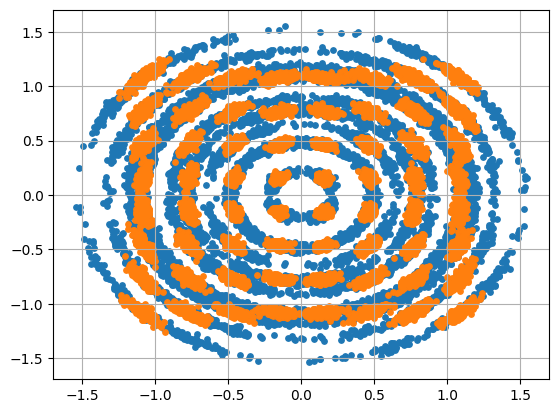

In [20]:
bits = binary_source([batch_size,block_size* bits_per_symbol])
x_mod = mapper(bits)
ptrs_x_mod = ptrs_adder(x_mod)
x_up = upsampler(ptrs_x_mod)
x_tx_filt = tx_filter(x_up)
# pn_out,_ = pn_Tx(x_tx_filt)
pn_out, _, _ = pn_tx(x_tx_filt)
y_channel = channel(pn_out, No)
y_channel_pn, _, _ = pn_rx(y_channel)
# y_channel_pn,_ = pn_Rx(y_channel)
y_rx_filt = rx_filter(y_channel_pn)
y = downsampler(y_rx_filt)

y_raw_data = tf.gather(y, ptrs_adder.data_indices, axis=1)
y_wpn_free_vec, y_data_vec = pn_compensate(y)

plt.figure()
plt.scatter(np.real(y_raw_data), np.imag(y_raw_data), s=15, alpha=1)
plt.scatter(np.real(y_data_vec), np.imag(y_data_vec), s=15, alpha=1)
plt.grid(True)
plt.show()

### Using my Phase noise model

(3, 16512)
(3, 16512)


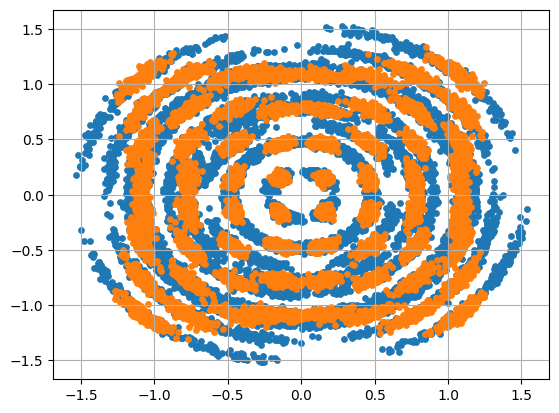

In [23]:
bits = binary_source([batch_size,block_size* bits_per_symbol])
x_mod = mapper(bits)
ptrs_x_mod = ptrs_adder(x_mod)
x_up = upsampler(ptrs_x_mod)
x_tx_filt = tx_filter(x_up)
pn_out,_ = pn_Tx(x_tx_filt)
# pn_out, _, _ = pn_tx(x_tx_filt)
y_channel = channel(pn_out, No)
# y_channel_pn, _, _ = pn_rx(y_channel)
y_channel_pn,_ = pn_Rx(y_channel)
y_rx_filt = rx_filter(y_channel_pn)
y = downsampler(y_rx_filt)

y_raw_data = tf.gather(y, ptrs_adder.data_indices, axis=1)
y_wpn_free_vec, y_data_vec = pn_compensate(y)

plt.figure()
plt.scatter(np.real(y_raw_data), np.imag(y_raw_data), s=15, alpha=1)
plt.scatter(np.real(y_data_vec), np.imag(y_data_vec), s=15, alpha=1)
plt.grid(True)
plt.show()

### Experimenting PTRS addition and removal

In [11]:
def get_ptrs_block_indices(block_length, ptrs_blocks_per_block, samples_per_block):
    edge = np.mod(block_length-ptrs_blocks_per_block*samples_per_block,ptrs_blocks_per_block-1)
    block_distance = (block_length-samples_per_block*ptrs_blocks_per_block-edge)/(ptrs_blocks_per_block-1)
    ptrs_block_indices = np.arange(np.floor(edge/2), np.floor(edge/2)+samples_per_block)

    for n in range(1,ptrs_blocks_per_block):
        ptrs_block_indices = np.concatenate([ptrs_block_indices, np.arange(ptrs_block_indices[-1]+block_distance+1, ptrs_block_indices[-1]+samples_per_block+block_distance+1)])

    all_indices = np.arange(block_length)
    data_indices = np.setdiff1d(all_indices, ptrs_block_indices)

    return ptrs_block_indices.astype(int), data_indices.astype(int)

In [27]:
ptrs_indices, data_indices = get_ptrs_block_indices(4096,32,4)
ptrs_indices_tensor = tf.convert_to_tensor(ptrs_indices)

In [13]:
ptrs_indices.dtype

dtype('int64')

In [14]:
ptrs_zero_row = tf.zeros_like(ptrs_indices)   # all zeros → row 0
ptrs_indices_2d = tf.transpose(tf.stack([ptrs_zero_row, ptrs_indices], axis=1),[0,1])  # shape [K, 2]

# data_zero_row = tf.zeros_like(data_indices)   # all zeros → row 0
# data_indices_2d = tf.transpose(tf.stack([data_zero_row, data_indices], axis=1),[0,1])  # shape [K, 2]
data_indices = tf.expand_dims(data_indices, axis=1)

In [15]:
data_indices.shape

TensorShape([3968, 1])

In [16]:
ptrs_indices_2d.shape

TensorShape([128, 2])

In [17]:
pilots = tf.squeeze(pilots)

In [18]:
pilots.shape

TensorShape([128])

In [19]:
resource_grid = tf.zeros([1,block_size_ptrs], dtype=tf.complex64)

In [20]:
resource_grid = tf.tensor_scatter_nd_update(
    resource_grid,
    ptrs_indices_2d,
    pilots
)

In [21]:
resource_grid = tf.tile(resource_grid, [batch_size, 1])


In [22]:
resource_grid_complete = tf.transpose(tf.tensor_scatter_nd_update(
    tf.transpose(resource_grid,[1, 0]),
    data_indices,
    tf.transpose(x_mod,[1, 0])
),[1, 0])

In [23]:
resource_grid.shape

TensorShape([3, 4096])

In [25]:
y.shape

TensorShape([3, 4096])

In [76]:
y_ptrs = tf.gather(y, ptrs_indices, axis=1)

In [77]:
y_ptrs.shape

TensorShape([3, 128])

In [114]:
print(x_up.shape)
print(x_tx_filt.shape)
print(x.shape)

(1, 16384)
(1, 16512)
(1, 4096)


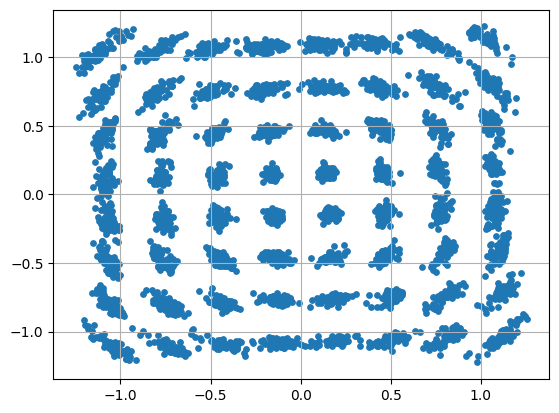

In [126]:
plt.figure()
plt.scatter(np.real(y), np.imag(y), s=15, alpha=1)
# plt.scatter(np.real(x_mod), np.imag(x_mod))
plt.grid(True)
plt.show()

In [92]:
y_data_vec.shape

TensorShape([3, 3968])

In [31]:
pilots.shape

TensorShape([128])

In [32]:
y.shape

TensorShape([3, 4096])

In [33]:
y_ptrs.shape

TensorShape([3, 128])

In [78]:
phase_estimate = y_ptrs * tf.math.conj(pilots)/tf.cast(tf.square(tf.abs(pilots)), tf.complex64)

In [35]:
phase_estimate.shape

TensorShape([3, 128])

In [61]:
phase_estimate[0,:10]

<tf.Tensor: shape=(10,), dtype=complex64, numpy=
array([1.0025334 +0.04957568j, 0.95649946-0.00929854j,
       1.0490583 +0.02849782j, 1.0178888 -0.00121192j,
       1.0360333 -0.03497332j, 1.0134647 +0.00391673j,
       1.0098261 +0.00822976j, 1.0200883 -0.01890788j,
       1.0015246 -0.0773858j , 1.0084246 -0.05720093j], dtype=complex64)>

In [62]:
phase_test = tf.reshape(phase_estimate,[batch_size, 32,4])
phase_test

<tf.Tensor: shape=(3, 32, 4), dtype=complex64, numpy=
array([[[1.0025334 +0.04957568j, 0.95649946-0.00929854j,
         1.0490583 +0.02849782j, 1.0178888 -0.00121192j],
        [1.0360333 -0.03497332j, 1.0134647 +0.00391673j,
         1.0098261 +0.00822976j, 1.0200883 -0.01890788j],
        [1.0015246 -0.0773858j , 1.0084246 -0.05720093j,
         0.9758866 -0.05632445j, 1.0097936 -0.12991151j],
        [0.9889708 -0.08901687j, 1.0166694 -0.16672233j,
         0.975615  -0.11622984j, 0.98239136-0.08860019j],
        [1.0389667 -0.09607345j, 0.9283667 -0.08976947j,
         0.9848383 -0.12544377j, 0.93057305-0.03313559j],
        [1.0014361 -0.00997365j, 1.0005518 +0.01955397j,
         0.9747356 -0.01815861j, 1.0255469 +0.02520007j],
        [1.009311  +0.02213175j, 0.94589174-0.01554865j,
         1.0006738 -0.00770967j, 0.94251615+0.0397533j ],
        [0.97673345+0.06250565j, 0.9770115 +0.01873926j,
         1.0142542 +0.01757422j, 1.0036757 +0.03300308j],
        [0.9850871 -0.0313

In [79]:
phase_estimate_mean = tf.reduce_mean(tf.reshape(phase_estimate,[batch_size, 32,4]), axis=-1)

In [37]:
phase_estimate_mean.shape

TensorShape([3, 32])

In [38]:
x_dense = tf.cast(tf.range(0, block_size_ptrs),tf.float32)

In [80]:
ptrs_avg_indices = tf.cast(tf.reduce_mean((tf.reshape(ptrs_indices,[-1, 32, 4])), axis =-1), tf.float32)

In [81]:
ptrs_indices

array([   0,    1,    2,    3,  132,  133,  134,  135,  264,  265,  266,
        267,  396,  397,  398,  399,  528,  529,  530,  531,  660,  661,
        662,  663,  792,  793,  794,  795,  924,  925,  926,  927, 1056,
       1057, 1058, 1059, 1188, 1189, 1190, 1191, 1320, 1321, 1322, 1323,
       1452, 1453, 1454, 1455, 1584, 1585, 1586, 1587, 1716, 1717, 1718,
       1719, 1848, 1849, 1850, 1851, 1980, 1981, 1982, 1983, 2112, 2113,
       2114, 2115, 2244, 2245, 2246, 2247, 2376, 2377, 2378, 2379, 2508,
       2509, 2510, 2511, 2640, 2641, 2642, 2643, 2772, 2773, 2774, 2775,
       2904, 2905, 2906, 2907, 3036, 3037, 3038, 3039, 3168, 3169, 3170,
       3171, 3300, 3301, 3302, 3303, 3432, 3433, 3434, 3435, 3564, 3565,
       3566, 3567, 3696, 3697, 3698, 3699, 3828, 3829, 3830, 3831, 3960,
       3961, 3962, 3963, 4092, 4093, 4094, 4095])

In [48]:
ptrs_avg_indices.shape

TensorShape([1, 32])

In [82]:
phase_estimate_interp_r = tfp.math.interp_regular_1d_grid(x=x_dense, x_ref_min = ptrs_avg_indices[0,0]
                                                        ,x_ref_max = ptrs_avg_indices[0,-1],
                                                         y_ref= tf.math.real(phase_estimate_mean))
phase_estimate_interp_i = tfp.math.interp_regular_1d_grid(x=x_dense, x_ref_min = ptrs_avg_indices[0,0]
                                                        ,x_ref_max = ptrs_avg_indices[0,-1],
                                                         y_ref= tf.math.imag(phase_estimate_mean))


In [83]:
phase_estimate_interp_r.shape

TensorShape([3, 4096])

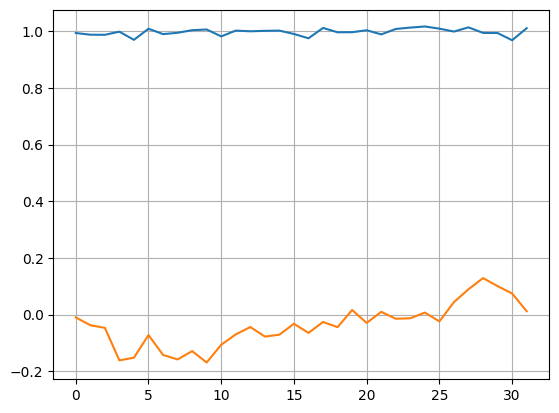

In [84]:
plt.figure()
plt.plot(range(0,32), np.real(phase_estimate_mean[0].numpy()))
plt.plot(range(0,32), np.imag(phase_estimate_mean[0].numpy()))

plt.grid(True)
plt.show()

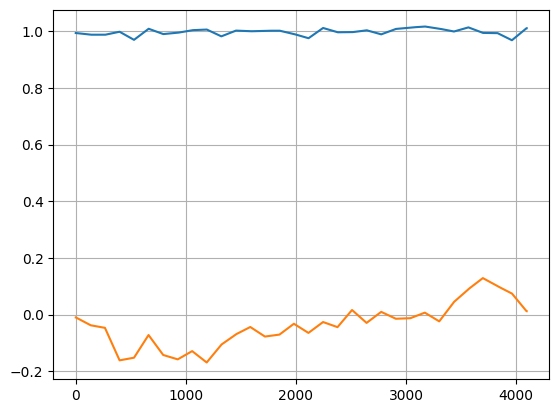

In [85]:
plt.figure()
plt.plot(x_dense, np.real(phase_estimate_interp_r[0].numpy()))
plt.plot(x_dense, np.real(phase_estimate_interp_i[0].numpy()))

plt.grid(True)
plt.show()

In [86]:
y.shape

TensorShape([3, 4096])

In [87]:
y_wpn_free = y / tf.complex(phase_estimate_interp_r,phase_estimate_interp_i)

### Testing 3gpp Phase noise model

In [32]:
%reset

In [33]:
import numpy as np
from sionna.phy.utils import complex_normal
import tensorflow as tf
import matplotlib.pyplot as plt

In [34]:
bandwidth = 960e3*4096
fc = 220e9
n_samples = 10**6
samples = n_samples
fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples//2)
fvec = fvec[1:]

In [35]:
# Number of plots
M = 4

fom = np.array([-215, -240, -175, -130])
fz  = np.array([np.inf, 1e4, 50.30e6, np.inf])
p   = np.array([10, 20, 20, 20])
k   = np.array([2, 1, 2, 3])

fc = 220e9
bandwidth = 960e3 * 4096
# samples = int(10e6)

fvec = (bandwidth / 2) * np.linspace(0, 1, 1 + samples // 2)

# Reshape parameters to (M, 1) so they broadcast over fvec
fom = fom[:, None]
fz  = fz[:, None]
p   = p[:, None]
k   = k[:, None]

PSD0 = fom + 20 * np.log10(fc) - 10 * np.log10(p)

S_ref = PSD0 + 10*np.log10((1 + (fvec / fz)**k) / (1 + fvec**k))

In [36]:
S_ref.shape

(4, 500001)

In [37]:
S_ref[3,:20]

array([ 83.83815366, -24.00078177, -33.03168164, -38.31441941,
       -42.06258151, -44.9698819 , -47.34531928, -49.35372297,
       -51.09348138, -52.62805705, -54.00078177, -55.24256233,
       -56.37621915, -57.41908234, -58.38462284, -59.28351954,
       -60.12438125, -60.91424941, -61.65895692, -62.3633898 ])

In [38]:
fvec.shape

(500001,)

In [39]:
f_loop = 187e3

mask_low  = fvec < f_loop
mask_high = fvec >= f_loop

S_lin = 10**(S_ref / 10)
S_out = np.where(
    fvec < f_loop,
    S_lin[0] + S_lin[1],
    S_lin[2] + S_lin[3]
)
S_out_dB = 10 * np.log10(S_out)

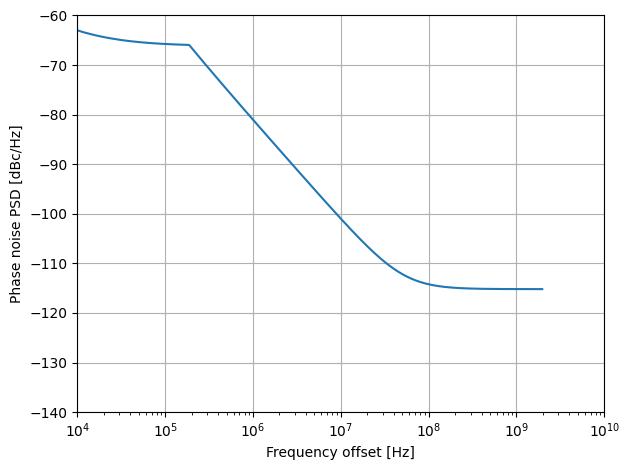

In [40]:
# Plot the PSD
fig = plt.figure()

# Main plot
ax1 = fig.add_subplot(111)
# ax1.semilogx(fvec_3, hFPwr_dB)
ax1.semilogx(fvec, S_out_dB)
ax1.grid(True)
ax1.set_xlabel('Frequency offset [Hz]')
ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
ax1.set_xlim([1e4, 1e10])
ax1.set_ylim([-140, -60])
plt.tight_layout()  # Adjust layout for subplots
#return ax
plt.show()

In [41]:
hFPwr_list = []
n_iter = 40

delta_f = bandwidth / tf.cast(samples, tf.float32)

In [42]:
S_out.shape

(500001,)

In [44]:
print(n_samples)# n_samples = 1000000
print(samples)

1000000
1000000


In [45]:
samples

1000000

In [46]:
lf = tf.expand_dims(S_out[1:],axis=0)

In [47]:
lf.shape

TensorShape([1, 500000])

In [48]:
samples

1000000

In [49]:
n_samples

1000000

In [50]:
delta_f

<tf.Tensor: shape=(), dtype=float32, numpy=3932.159912109375>

In [51]:
batch_size = 1

In [52]:
for itervalue in range(n_iter):
    tf.print('iter: ',itervalue)

    src_f = complex_normal([batch_size, samples])*(tf.sqrt(tf.cast(delta_f, tf.complex64)))*samples

    psd_squared = tf.concat([tf.math.conj(tf.reverse(lf, axis=[-1])),lf], axis=-1)

    f_a = tf.cast(src_f, tf.complex128) * tf.complex(tf.sqrt(psd_squared), tf.cast(0.0,tf.float64))

    theta_use = tf.signal.ifft(tf.signal.fftshift(f_a))

    phase_noise = tf.exp(1j*tf.cast(tf.sqrt(2.0),tf.complex128)* tf.complex(tf.math.real(theta_use),tf.cast(0.0,tf.float64)))
    phase_noise = tf.cast(phase_noise, tf.complex64)

    pn_without_carrier = phase_noise - tf.complex(1.0, 0.0)

    # --- PSD estimation ---

    hF = tf.signal.fft(pn_without_carrier)/ (
        tf.cast(n_samples, tf.complex64) * tf.sqrt(tf.cast(delta_f, tf.complex64))
    )

    hFPwr = tf.math.real(hF * tf.math.conj(hF))  # linear PSD
    hFPwr_list.append(hFPwr)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39


In [53]:
hFPwr_stack = tf.stack(hFPwr_list, axis=0)
hFPwr_avg = tf.signal.fftshift(tf.reduce_mean(hFPwr_stack, axis=0))
fvec_3 = np.arange(-samples//2, samples//2) / samples * bandwidth
hFPwr_dB = tf.squeeze(10.0 * tf.math.log(hFPwr_avg) / tf.math.log(10.0))


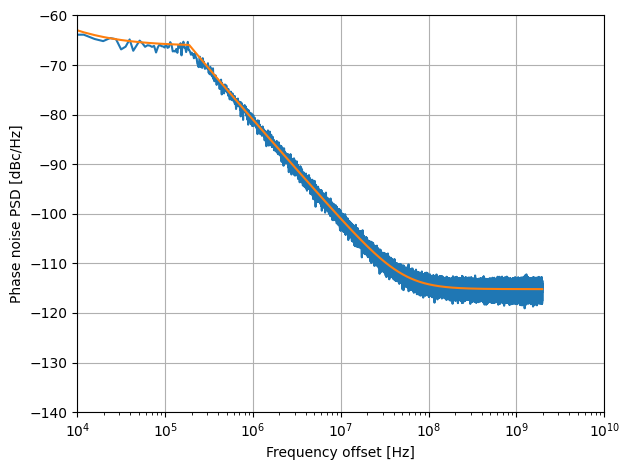

In [55]:
# Plot the PSD
fig = plt.figure()

# Main plot
ax1 = fig.add_subplot(111)
ax1.semilogx(fvec_3, hFPwr_dB)
ax1.semilogx(fvec, S_out_dB)
ax1.grid(True)
ax1.set_xlabel('Frequency offset [Hz]')
ax1.set_ylabel('Phase noise PSD [dBc/Hz]')
ax1.set_xlim([1e4, 1e10])
ax1.set_ylim([-140, -60])
plt.tight_layout()  # Adjust layout for subplots
#return ax
plt.show()